### Empirical Example for RobustiPY (Type 4)!

#### This example is designed to show how the LRobust class can be used to estimate a model with a binary dependent variable.

For this, we utilise the "Framingham" heart disease dataset which includes over 4,240 records, 16 columns and 15 attributes. The goal of the dataset is to predict whether the patient has 10-year risk of future (CHD) coronary heart disease. RobustiPy is well placed to analyse this because of the large feature space, and the focus on out-of-sample model accuracy.

Lets first load in some of the things that we need:

In [1]:
import os
import warnings
import kagglehub
import pandas as pd
import statsmodels.api as sm
from robustipy.models import LRobust
from sklearn.exceptions import ConvergenceWarning
from robustipy.prototypes import MissingValueWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings(action="ignore", category=MissingValueWarning,
                        module=r"robustipy\.prototypes")

Get the dataset from kagglehub:

In [2]:
path = kagglehub.dataset_download("aasheesh200/framingham-heart-study-dataset")

And then, load the dataset:

In [3]:
df = pd.read_csv(os.path.join(path, 'framingham.csv'))

Then, wrangle a simple dataset and attempt to make it equivilent to [Wilson et al.](https://pubmed.ncbi.nlm.nih.gov/9603539/).

In [4]:
required_cols = [
    'age', 'male', 'totChol', 'sysBP', 'BPMeds',
    'currentSmoker', 'cigsPerDay', 'diabetes', 'BMI',
    'heartRate', 'glucose', 'TenYearCHD'
]
df_clean = df.dropna(subset=required_cols).copy()  # copy() avoids view issues

def age_score(row):
    # ... [same implementation] ...
    age, sex = row['age'], row['male']
    bins_m = [(20,34,-9),(35,39,0),(40,44,3),(45,49,6),(50,54,8),
              (55,59,10),(60,64,11),(65,69,12),(70,74,14),(75,79,16)]
    bins_f = [(20,34,-7),(35,39,3),(40,44,6),(45,49,8),(50,54,10),
              (55,59,12),(60,64,14),(65,69,16),(70,74,18),(75,79,20)]
    for lo, hi, pts in (bins_m if sex==1 else bins_f):
        if lo <= age <= hi:
            return pts
    return 0

def chol_score(row):
    chol, sex = row['totChol'], row['male']
    bins = [(0,159,0),(160,199,4),(200,239,8),(240,279,11),(280,1000,13)]
    for lo, hi, pts in bins:
        if lo <= chol <= hi:
            return pts
    return 0

def bp_score(row):
    sbp, med = row['sysBP'], row['BPMeds']
    if med:
        bins = [(0,119,0),(120,129,1),(130,139,2),(140,159,2),(160,1000,3)]
    else:
        bins = [(0,119,0),(120,129,0),(130,139,1),(140,159,1),(160,1000,2)]
    for lo, hi, pts in bins:
        if lo <= sbp <= hi:
            return pts
    return 0

def smoke_score(row):
    return 2 if row['currentSmoker']==1 else 0

def diabetes_score(row):
    return 2 if row['diabetes']==1 else 0

df_clean.loc[:, 'pts_age']   = df_clean.apply(age_score, axis=1)
df_clean.loc[:, 'pts_chol']  = df_clean.apply(chol_score, axis=1)
df_clean.loc[:, 'pts_bp']    = df_clean.apply(bp_score, axis=1)
df_clean.loc[:, 'pts_smoke'] = df_clean.apply(smoke_score, axis=1)
df_clean.loc[:, 'pts_diab']  = df_clean.apply(diabetes_score, axis=1)

df_clean.loc[:, 'total_points'] = (
    df_clean[['pts_age','pts_chol','pts_bp','pts_smoke','pts_diab']].sum(axis=1)
)

y = df_clean['TenYearCHD']
X = sm.add_constant(df_clean['total_points'])
model = sm.Logit(y, X).fit(disp=False)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3749
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 May 2025   Pseudo R-squ.:                 0.04839
Time:                        12:34:46   Log-Likelihood:                -1524.2
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 1.390e-35
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.6763      0.182    -20.245      0.000      -4.032      -3.320
total_points     0.1012      0.009     11.804      0.000       0.084       0.118


Lets call the LRobust class, similar but different to the other examples

In [5]:
framingham = LRobust(y=['TenYearCHD'], x=['BMI'], data=df_clean)

# Now, lets 'fit' the model and vary over the controls
framingham.fit(controls=['age', 'male', 'totChol', 'sysBP', 'BPMeds',
                         'currentSmoker', 'cigsPerDay', 'diabetes',
                         'heartRate', 'glucose'],
               draws=1000,
               oos_metric='r-squared',
               kfold=10,
               threshold=2000000,
               seed=192733
              )

# Finally, get the results object that we'll need to visualise and print out the results:
framingham_result = framingham.get_results()

[LRobust] Running with n_cpu=31, draws=1000


Output()

Visualise the results:

ValueError: The shape of the shap_values matrix does not match the shape of the provided data matrix. Perhaps the extra column in the shap_values matrix is the constant offset? Of so just pass shap_values[:,:-1].

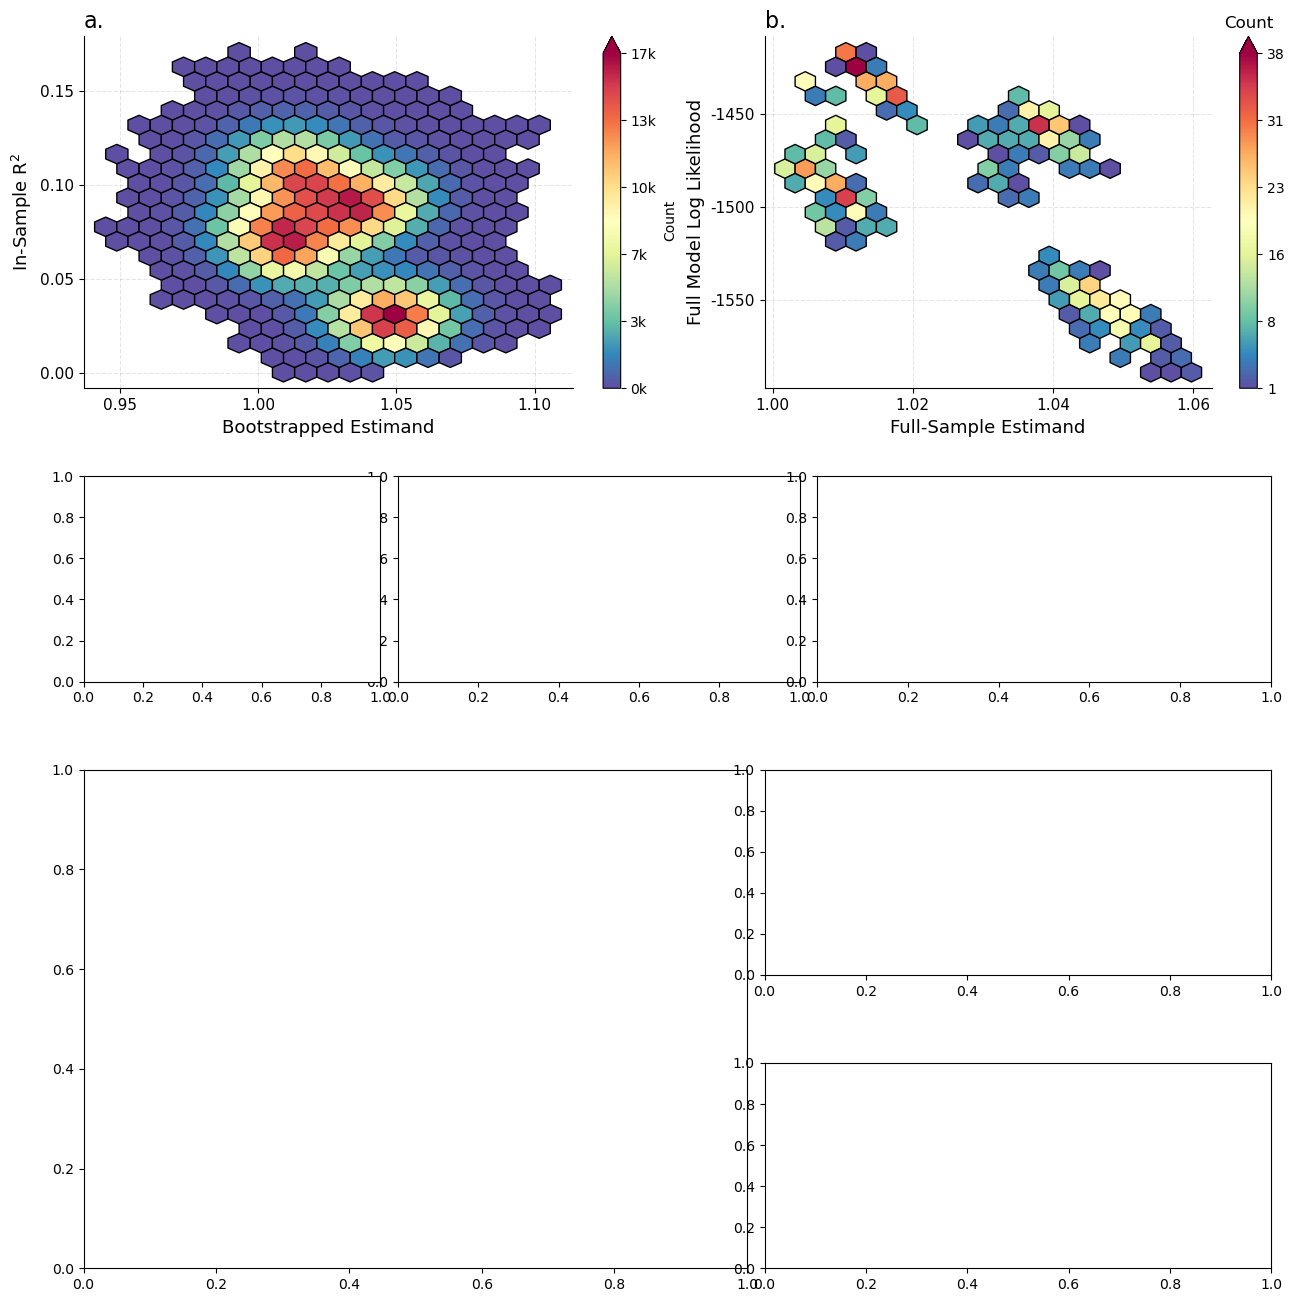

In [6]:
framingham_result.plot(
                       ic='hqic',
                       figsize=(16, 16),
                       project_name='framingham_example',
                       figpath = '../figures',
                       loess=True,
                       ext='pdf',
                       oddsratio=True)

And, finally, print a model summary:

In [ ]:
framingham_result.summary(digits=2)